# Tools for Modern Macroeconometrics: Homework 3

# Jan Suchánek

In [45]:
library(dplyr)
if (!require(forecast)) install.packages("forecast")
if (!require(forecast)) install.packages("uroot")
library(stats)
library(repr)
library(tseries)
library(readr)
library(forecast)
#library(uroot)
library(urca)
library(strucchange)
install.packages("mFilter")
library(mFilter)
install.packages("neverhpfilter")
library(neverhpfilter)
library(xts)

Warning message:
"package 'mFilter' is in use and will not be installed"


  There is a binary version available but the source version is later:
              binary source needs_compilation
neverhpfilter  0.3-1  0.4-0             FALSE



installing the source package 'neverhpfilter'

Loading required package: xts

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last



## 1. Estimate the spectrum of the time series (use logs of levels), then estimate the spectrum of its log differences.

For the purpose of this exercise I use quarterly seasonally adjusted Real GDP of Finland. I will start by loading the data and gaining some general idea about structure.

https://fred.stlouisfed.org/series/CLVMNACSCAB1GQFI

In [53]:
finland <- read.csv("CLVMNACSCAB1GQFI.csv")

colnames(finland) <- c("date", "real_gdp")
head(finland)

finland %>% glimpse

date,real_gdp
1990-01-01,32133.4
1990-04-01,31691.2
1990-07-01,31012.2
1990-10-01,30834.4
1991-01-01,30233.1
1991-04-01,29871.2


Observations: 128
Variables: 2
$ date     <fct> 1990-01-01, 1990-04-01, 1990-07-01, 1990-10-01, 1991-01-01...
$ real_gdp <dbl> 32133.4, 31691.2, 31012.2, 30834.4, 30233.1, 29871.2, 2925...


To estimate the spectrum, I use predefined function from the seminar.

In [ ]:
# Function that calculates the fast fourier transformation
# and plots the periodogram
fftMy <- function(y,T,t,smoothFact){
  
  # periodogram    ... y in term of scales, x in term of periods
  # vs. spectogram ... commented lines 
  
  Ft <- abs(fft(y)/(T/2))
  #Ft <- abs(Ft)^2 # y axis scaled
  Ft <- Ft[1:ceiling(T/2)]
  
  #freqs <- t - 2*pi/T
  #freqs <- freqs[1:ceiling(T/2)] # x axis in angular, y axis unscaled
  freqs <- 0:(ceiling(T/2)-1) # x axis in periods, y axis scaled
  
  plot(freqs, Ft, type="h", xlab="Period", ylab=expression(f(x))) #, xlim=c(0, pi))
  points(freqs, Ft, pch=20)
  
  # smoothing -> spectrum
  # smoothFact = T/5 
  lines(smooth.spline(freqs,Ft, df=smoothFact), col="OrangeRed")
  
}

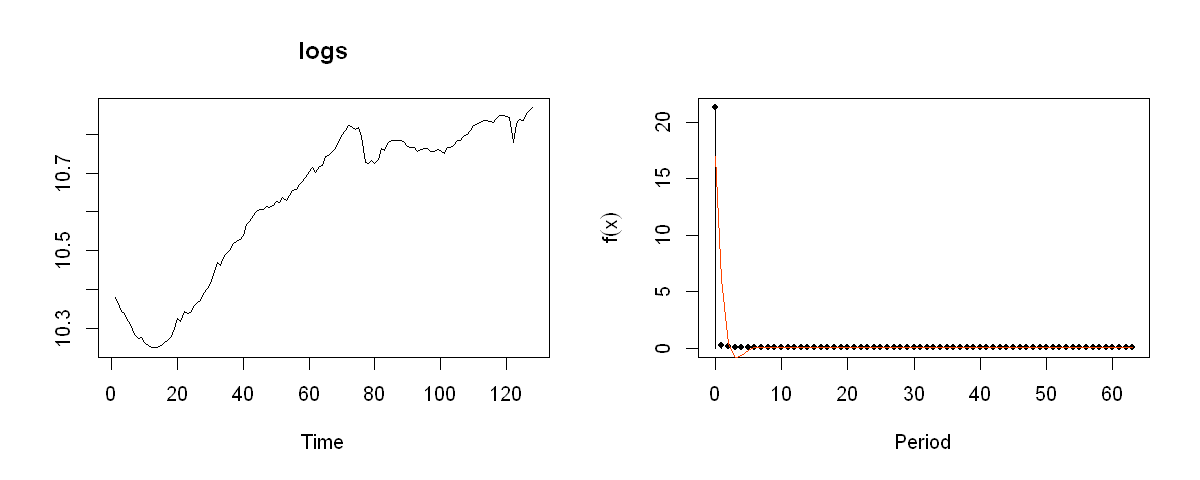

In [35]:
par(mfrow = c(1, 2))
options(repr.plot.width = 10, repr.plot.height = 4)

gdp_log <- log(finland$real_gdp)
ts.plot(gdp_log, main = "logs", ylab = "")
T <- length(gdp_log)
t <- (1:T)*2*pi/T
fftMy(gdp_log,T,t,T/5)

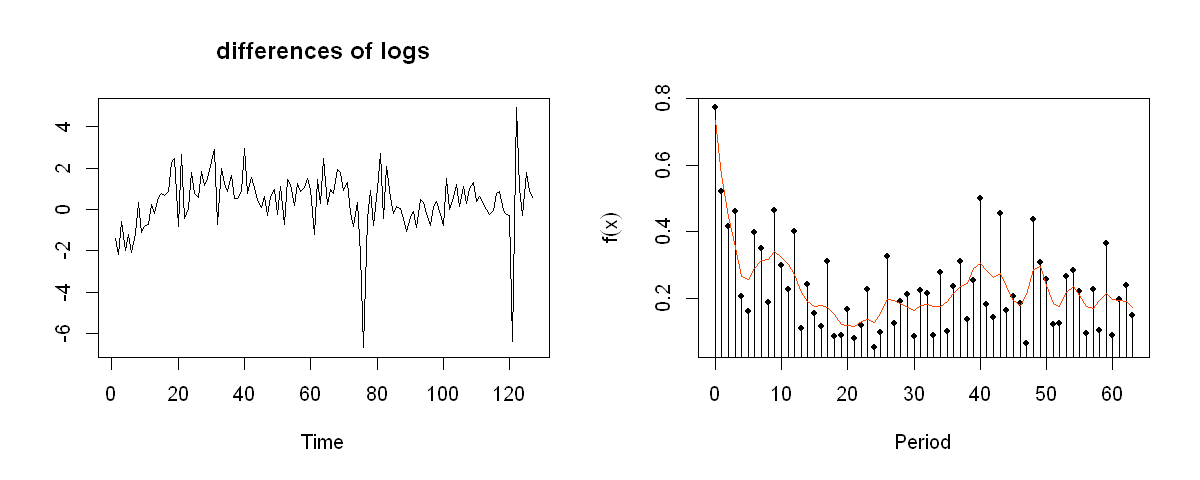

In [37]:
par(mfrow = c(1, 2))
gdp_log_diff <- diff(log(finland$real_gdp), 1) * 100
ts.plot(gdp_log_diff, main = "differences of logs", ylab = "")
T <- length(gdp_log_diff)
t <- (1:T)*2*pi/T
fftMy(gdp_log_diff,T,t,T/5)

## 2. Estimate the cyclical components using the Hodrick-Prescott filter, the Baxter-King filter, and Hamilton's regression filter. Compare the resulting cycles and their respective spectra. Compare average lengths and correlations of the cycle. 


Title:
 Hodrick-Prescott Filter 

Call:
 mFilter::hpfilter(x = gdp_log_diff, freq = 1600, type = "lambda")

Method:
 hpfilter

Filter Type:
 lambda

Series:
 gdp_log_diff

Descriptive Statistics:
 
  gdp_log_diff         Trend              Cycle         
 Min.   :-6.6969   Min.   :-1.76010   Min.   :-6.70949  
 1st Qu.:-0.2412   1st Qu.: 0.04247   1st Qu.:-0.44812  
 Median : 0.5296   Median : 0.35946   Median : 0.04877  
 Mean   : 0.3858   Mean   : 0.38582   Mean   : 0.00000  
 3rd Qu.: 1.1013   3rd Qu.: 0.76604   3rd Qu.: 0.59279  
 Max.   : 4.9073   Max.   : 1.29659   Max.   : 4.54647  

In-sample error measures:
       ME       MSE       MAE       MPE      MAPE 
1.273e-17 1.580e+00 7.883e-01 6.595e-01 1.548e+00 



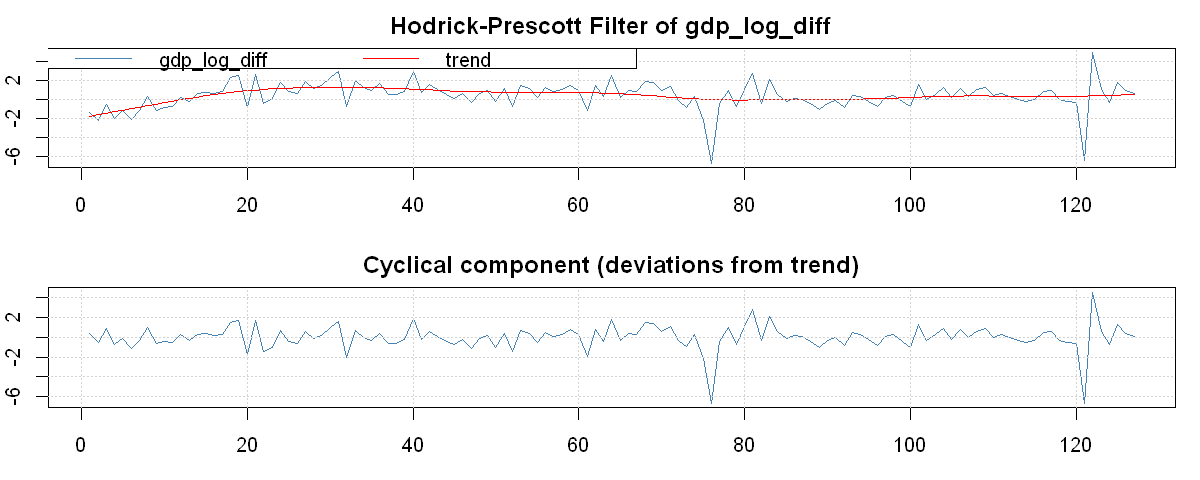

In [43]:
# Hodrick-Prescott filter
hpfinland <- mFilter::hpfilter(gdp_log_diff,freq=1600,type="lambda")

summary(hpfinland)
plot(hpfinland)


Title:
 Baxter-King Filter 

Call:
 bkfilter(x = gdp_log_diff)

Method:
 bkfilter

Filter Type:
 fixed

Series:
 gdp_log_diff

Descriptive Statistics:
 
  gdp_log_diff         Trend              Cycle          
 Min.   :-6.6969   Min.   :-1.94666   Min.   :-5.948651  
 1st Qu.:-0.2412   1st Qu.:-0.06661   1st Qu.:-0.425785  
 Median : 0.5296   Median : 0.63531   Median :-0.000194  
 Mean   : 0.3858   Mean   : 0.41987   Mean   :-0.007919  
 3rd Qu.: 1.1013   3rd Qu.: 0.98454   3rd Qu.: 0.486156  
 Max.   : 4.9073   Max.   : 1.67948   Max.   : 4.877428  
                   NA's   :6          NA's   :6          

In-sample error measures:
       ME       MSE       MAE       MPE      MAPE 
-0.007919  1.218147  0.694560  0.761642  1.671991 



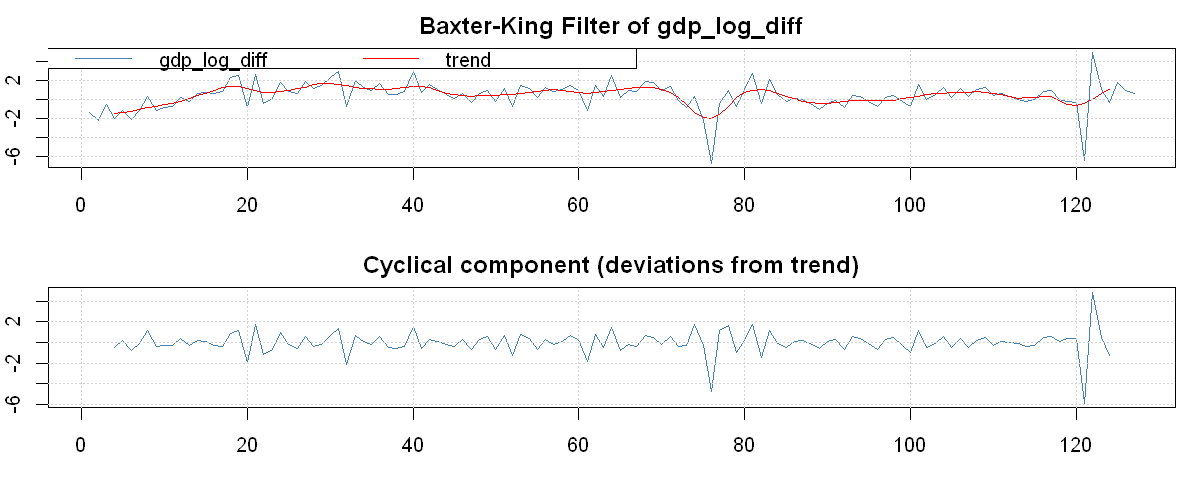

In [44]:
# Baxter-King filter

bkfinland <- bkfilter(gdp_log_diff)

summary(bkfinland)

plot(bkfinland)

Warning message in yth_filter(gdp_log_diff_xts, h = 8, p = 4):
"Your xts object doesn't have a dimnames attribute, aka names(your_xts) is NULL, which would've produced an error.
    Thus it has been given the name 'y' within the scope, and for the output, of this function."

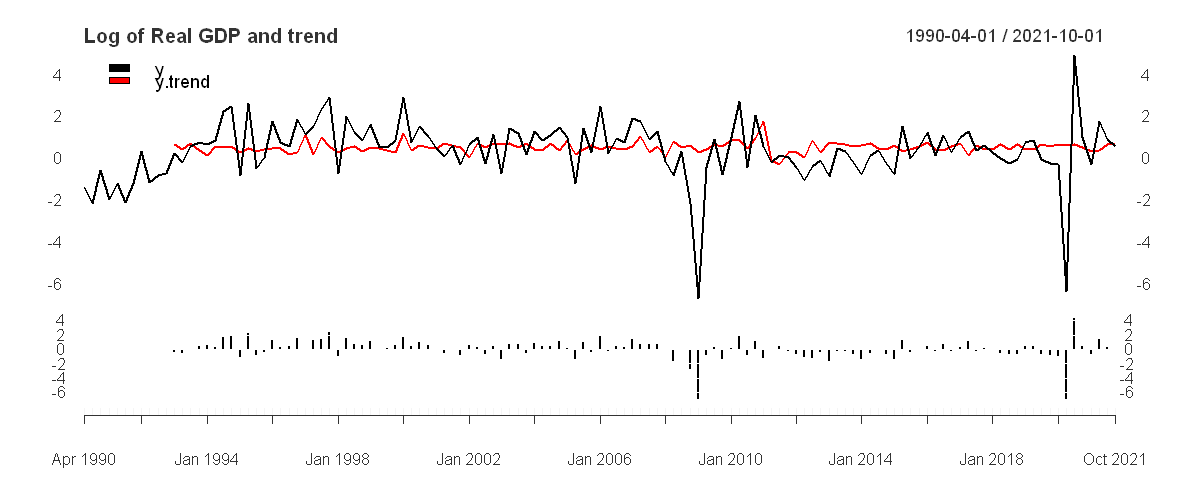

In [61]:
# Hamilton's regression filter

dates <- seq(as.Date("1990-04-01"), length = nrow(finland)-1, by = "quarters")
gdp_log_diff_xts <- xts(gdp_log_diff, order.by = dates)

gdp_HAM <- yth_filter(gdp_log_diff_xts, h= 8, p = 4)
par(mfrow=c(1,1))
plot(gdp_HAM["1990/"][,1:2], grid.col = "white", legend.loc = "topleft", main = "Log of Real GDP and trend", panels = 'lines(gdp_HAM["1990/"][,3], type="h", on=NA)')


In [54]:
?yth_filter